Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/16.generative_deep_learning-part_2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%%capture
!pip install -q datasets diffusers torchinfo einops

# Generative Deep Learning - Part 2

This notebook focuses on two other generative deep learning models: Normalizing Flows and Diffusion Models (DDPMs).

## Normalizing Flows  

Normalizing flows are a generative modeling technique that transforms a simple probability distribution (e.g., a standard Gaussian) into a complex one using a sequence of invertible functions.  

Given a simple random variable $\mathbf{z}$, we apply a sequence of transformations $f_1, f_2, \dots, f_K$ to obtain a more complex variable $\mathbf{x}$ that resembles the dataset:  

$$
\mathbf{x} = f_K \circ f_{K-1} \circ \dots \circ f_1 (\mathbf{z})
$$

For an invertible function $f: \mathbb{R}^d \to \mathbb{R}^d$, the probability density of $\mathbf{x}$ is:  

$$
p_x(\mathbf{x}|\theta) = p_z(g(\mathbf{x}, \theta)) \left| \det \mathbf{J}(\mathbf{x}) \right|
$$

where $g = f^{-1}$ is the inverse function, $\theta$ are the model parameters, and $\mathbf{J}$ is the Jacobian matrix:  

$$
J_{ij}(\mathbf{x}) = \frac{\partial g_i(\mathbf{x}, \theta)}{\partial x_j}
$$

### Training  

Normalizing flows are trained using a dataset $\mathbf{D}$ with $N$ examples by maximizing the log-likelihood (LL) or minimizing its negative (NLL):  

$$
\hat{\theta}_{NLL} = \arg\min_{\theta} \sum_{i=1}^{N} \left[ -\log p_z(g(\mathbf{x}_i, \theta)) + \log \left| \det \mathbf{J}(\mathbf{x}_i) \right| \right]
$$

### Practical Requirements  

For normalizing flows to be effective, the transformation layers \( f_k \) must:  
- Be expressive enough to map a standard normal distribution to an arbitrary density.  
- Be invertible, ensuring a one-to-one mapping.  
- Have an efficiently computable inverse.  
- Allow efficient computation of the Jacobian determinant for the forward or inverse mapping.  

### An example: Coupling Flows  

Coupling flows transform a simple prior distribution into a complex one while ensuring an efficiently computable Jacobian determinant.  

- The latent vector $\mathbf{z}$ is split into two parts: $\mathbf{z} = (\mathbf{z}_A, \mathbf{z}_B)$.  
- The transformation is defined as:  

  $$
  \mathbf{x}_A = \mathbf{z}_A, \quad  
  \mathbf{x}_B = \mathbf{z}_B \odot \exp(s(\mathbf{z}_A)) + t(\mathbf{z}_A)
  $$

  where $s(\mathbf{z}_A)$ and $t(\mathbf{z}_A)$ are **scale** and **translation** functions (neural networks), $\odot$ denotes element-wise multiplication, and $(\mathbf{x}_A, \mathbf{x}_B)$ is the transformed output.  

- The transformation is **invertible**:  

  $$
  \mathbf{z}_A = \mathbf{x}_A, \quad  
  \mathbf{z}_B = (\mathbf{x}_B - t(\mathbf{z}_A)) \odot \exp(-s(\mathbf{z}_A))
  $$

### Log-Determinant of the Jacobian  

To compute the change in log probability, we use the Jacobian:  

$$
\mathbf{J} =
\begin{bmatrix}
\frac{\partial \mathbf{z}_A}{\partial \mathbf{x}_A} & \frac{\partial \mathbf{z}_A}{\partial \mathbf{x}_B} \\
\frac{\partial \mathbf{z}_B}{\partial \mathbf{x}_A} & \text{diag}(\exp(-s(\mathbf{z}_A)))
\end{bmatrix}
$$

Since $\mathbf{J}$ is lower triangular, its determinant simplifies to:  

$$
\left| \det \mathbf{J} \right| = \prod \exp(-s(\mathbf{z}_A))
$$

and its log is:  

$$
\log \left| \det \mathbf{J} \right| = -\sum s(\mathbf{z}_A)
$$

This allows **efficient density estimation** without computing full matrix determinants.  

Let's get started! Let's see how such a model is implemented.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

First, we need a training dataset. We'll use a noisy version of the function:  

$$
x_1 = \sin(2\pi x_0) + \text{noise}
$$

to generate it. This will be an unsupervised dataset with no need for labels (or targets).

In [ ]:
x0 = torch.linspace(-1, 1, 1000)    # 1000 points from -1 to 1
x1 = torch.sin(2 * torch.pi * x0)   # Sinusoidal function
noise = 0.3 * torch.randn(x1.shape)
x1 = x1 + noise

X = torch.stack([x0, x1], dim=1)

  

Next, we create the training dataset and its data loader.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

ds_train = TensorDataset(X)
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)

Here is what the dataset looks like:

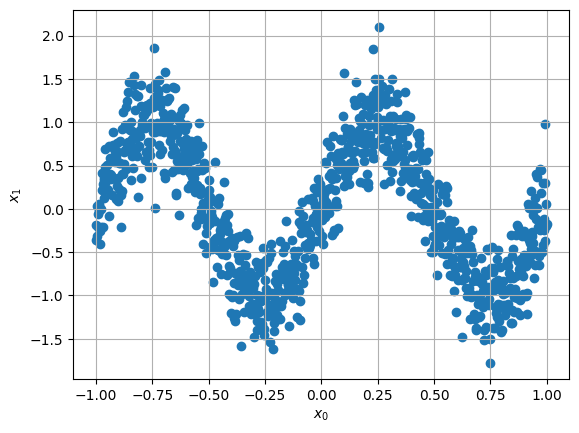

In [ ]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.show()

We are now ready to implement a simple coupling flow-based model to estimate the probability distribution of this data and generate similar new examples.  

First, we define the coupling layer module—a PyTorch module that implements the **scale** $s(\mathbf{z}_A)$ and **translation** $t(\mathbf{z}_A)$ neural networks. Both networks will produce outputs of the same size as their inputs.

In [ ]:
class CouplingLayer(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net_s = nn.Sequential(
            nn.Linear(dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim // 2),
            nn.Tanh()
        )
        self.net_t = nn.Sequential(
            nn.Linear(dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim // 2)
        )

    def forward(self, x, dir="forward"):
        x1, x2 = x[:, :x.shape[1] // 2], x[:, x.shape[1] // 2:]
        if dir == "forward":
            s = self.net_s(x1)
            t = self.net_t(x1)
            x2 = x2 * torch.exp(s) + t
            log_det_jacobian = torch.sum(s, dim=1)
        else:
            s = self.net_s(x1)
            t = self.net_t(x1)
            x2 = (x2 - t) * torch.exp(-s)
            log_det_jacobian = -torch.sum(s, dim=1)

        return torch.cat([x1, x2], dim=1), log_det_jacobian

Next, we use this coupling layer to build our simple flow-based model. By default, this model will have 6 coupling layers.

In [ ]:
class FlowModel(nn.Module):
    def __init__(self, n_layers=6, hidden_dim=64):
        super().__init__()
        self.layers = nn.ModuleList([
            CouplingLayer(dim=2, hidden_dim=hidden_dim) for _ in range(n_layers)
        ])

    def forward(self, x):
        log_det_jacobian_sum = 0.0
        for layer in self.layers:
            x, log_det_jacobian = layer(x)
            log_det_jacobian_sum += log_det_jacobian

        return x, log_det_jacobian_sum

    def inverse(self, z):
         for layer in reversed(self.layers):
            z, _ = layer(z, dir="backward")
         return z

    def log_proba(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = -0.5 * torch.sum(z**2, dim=1) - 0.5 * np.log(2 * np.pi) * z.size(1)
        return torch.mean(log_prob_z + log_det_jacobian)

    def sample(self, n_samples):
        z = torch.randn(n_samples, 2)
        samples = self.inverse(z)
        return samples

In this model, the log-likelihood is given by:  

$$
\mathcal{L}(x) = \log p(g(\mathbf{x}_i, \theta)) + \log \left| \det \mathbf{J}(\mathbf{x}_i) \right| = \log p(\mathbf{z}) + \log \left| \det \mathbf{J}(\mathbf{x}_i) \right|
$$

Since:

$$
\log p(\mathbf{z}) = \log \left( \frac{1}{\sqrt{2\pi}} e^{-\frac{\mathbf{z}^2}{2}} \right) = -\frac{1}{2} \log (2\pi) - \frac{\mathbf{z}^2}{2}
$$

The final log-likelihood simplifies to:

$$
\mathcal{L}(x) =  -\frac{1}{2} \log (2\pi) - \frac{\mathbf{z}^2}{2} + \log \left| \det \mathbf{J}(\mathbf{x}_i) \right|
$$

which is implemented by the `log_proba` function in the above class.  

Using this class, we now define our normalizing flow model.

In [ ]:
model = FlowModel()

Before training the model, we'll use the `sample` function to generate 500 new examples.



In [ ]:
pre_samples = model.sample(500)

Some of the generated examples fall outside the \( x_0 \) and \( x_1 \) ranges of the dataset. To make a better comparison, we'll exclude the examples that fall outside these ranges.

In [ ]:
pre_samples = pre_samples[pre_samples[:, 0] >= -1]
pre_samples = pre_samples[pre_samples[:, 0] <= 1]
pre_samples = pre_samples[pre_samples[:, 1] >= -1.75]
pre_samples = pre_samples[pre_samples[:, 1] <= 1.75]
len(pre_samples)

211

Let's plot these samples.

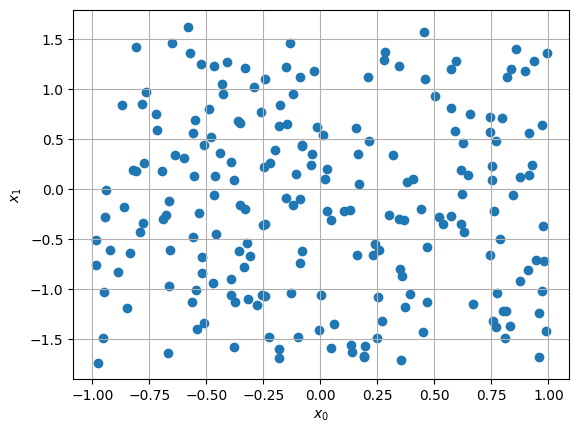

In [ ]:
pre_samples = pre_samples.detach().numpy()
plt.scatter(pre_samples[:,0], pre_samples[:,1])
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.show()

These examples are random and not similar or representative of the actual training data.

Now, we proceed to train the model. First, here is the optimizer:



In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

We are now ready to train the model. For the loss, we will use the negative log-likelihood.

In [ ]:
epochs = 100
hist = dict(loss=[0] * epochs)

for epoch in range(epochs):
    for [batch] in dl_train:
        loss = - model.log_proba(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        hist['loss'][epoch] += loss.item()

    hist['loss'][epoch] /= len(dl_train)
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: 3d}: loss={hist['loss'][epoch]:.4f}")

Epoch   1: loss=2.2177
Epoch  10: loss=1.4304
Epoch  20: loss=1.3618
Epoch  30: loss=1.3629
Epoch  40: loss=1.3530
Epoch  50: loss=1.3429
Epoch  60: loss=1.3399
Epoch  70: loss=1.3444
Epoch  80: loss=1.3681
Epoch  90: loss=1.3536
Epoch  100: loss=1.3675


Let's plot the learning curve:

<Axes: >

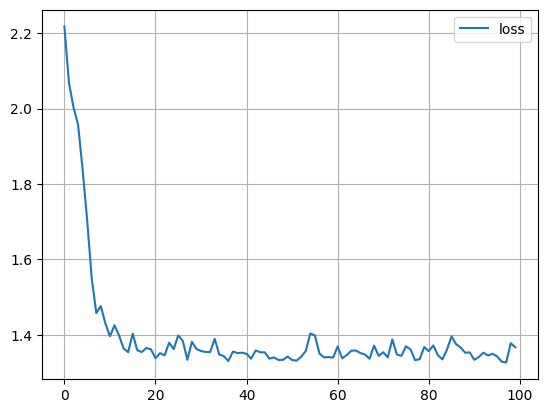

In [ ]:
pd.DataFrame(hist).plot(grid=True)

Next, we generate 500 new examples using the trained model.

In [ ]:
samples = model.sample(500)

Let's plot these samples:

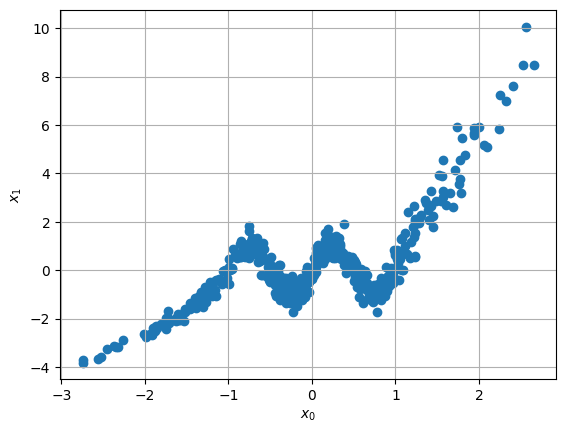

In [ ]:
samples = samples.detach().numpy()
plt.scatter(samples[:,0],samples[:,1])
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.show()

We can observe the same sinusoidal pattern seen in the training dataset. Limiting the generated samples to fall within the same ranges of $x_0$ and $x_1$ as in the dataset provides a clearer picture of how well the model performs.


In [ ]:
samples = samples[samples[:, 0] >= -1]
samples = samples[samples[:, 0] <= 1]
samples = samples[samples[:, 1] >= -1.75]
samples = samples[samples[:, 1] <= 1.75]
len(samples)

343

Finally, we make the comparison between the original training dataset, the generated samples before training, and the generated samples after training.

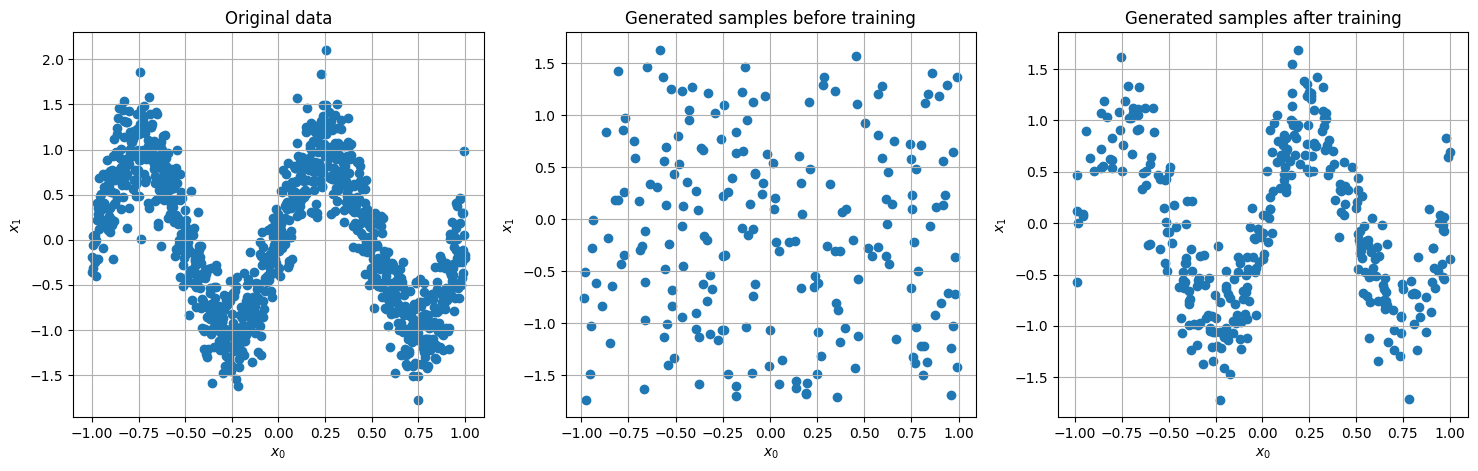

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].scatter(X[:,0],X[:,1])
ax[0].set_xlabel("$x_0$")
ax[0].set_ylabel("$x_1$")
ax[0].set_title("Original data")
ax[0].grid()

ax[1].scatter(pre_samples[:,0],pre_samples[:,1])
ax[1].set_xlabel("$x_0$")
ax[1].set_ylabel("$x_1$")
ax[1].set_title("Generated samples before training")
ax[1].grid()

ax[2].scatter(samples[:,0],samples[:,1])
ax[2].set_xlabel("$x_0$")
ax[2].set_ylabel("$x_1$")
ax[2].set_title("Generated samples after training")
ax[2].grid()

As you can see, the generated samples after training closely resemble the original data, which demonstrates how well the model has captured the distribution of the original dataset.

## Diffusion Models (DDPMs)

**Denoising Diffusion Probabilistic Models (DDPMs)** are a class of generative models that learn to generate data by progressively denoising a randomly sampled noise vector.  

The process consists of two phases:  
* **Forward (Diffusion) Process** – A known amount of Gaussian noise is iteratively added to the data, gradually transforming it into pure noise.  
* **Reverse (Denoising) Process** – A neural network is trained to reverse this noising process, step by step, to reconstruct the original data distribution.  

DDPMs generate high-quality samples and are widely used in applications like image and audio synthesis.

This notebook implements a simple DDPM model and train it on the MNIST dataset. It shows how DDPMs work, how they are trained and used to generate new samples. Let's load the data first:

In [7]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load the MNIST training dataset
ds_train = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# Create the training data loader
dl_train = DataLoader(
    ds_train, batch_size=128, shuffle=True
)

next(iter(dl_train))[0].shape

torch.Size([128, 1, 28, 28])

Here is one example image:

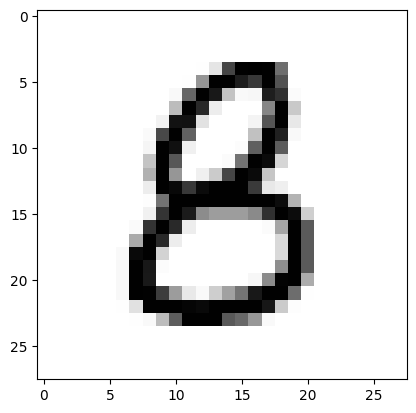

In [9]:
import matplotlib.pyplot as plt
# Get one example image from the MNIST dataset
example_image, _ = next(iter(dl_train))
example_image = example_image[0]  # Get the first image from the batch

# Display the image
plt.imshow(example_image.squeeze(), cmap='Grays')
plt.show()

### Forward Process

The forward process of DDMS involve taking an image like this and incrementally over many steps add noise to it until the image becomes bure noice (standard guassian) 

Tthe forward process is defined as a **Markovian process** that iteratively applies Gaussian noise over $T$ steps:

$$\mathbf{z}_1 = \sqrt{1-\beta_1} \text{ . } \mathbf{x} + \sqrt{\beta_1} \text{ . } \epsilon_1\\
\cdots\\
\mathbf{z}_T = \sqrt{1-\beta_T} \text{ . } \mathbf{z}_{T-1} + \sqrt{\beta_T} \text{ . }  \epsilon_T
$$

such that

$$
p(\mathbf{z}_t \mid \mathbf{z}_{t-1}) = \mathcal{N}_{\mathbf{z}_t}( \sqrt{1 - \beta_t} \mathbf{z}_{t-1}, \beta_t \mathbf{I})
$$

where:
- $\beta_t \in (0,1)$ is a variance schedule controlling the amount of noise added at each step.
- $\mathbf{I}$ is the identity matrix.
- The term $\sqrt{1 - \beta_t}$ scales the previous step while $\beta_t \mathbf{I}$ injects new noise.


Fortunately, there is a closed-form expression for $p(\mathbf{z}_t|\mathbf{x})$, which allows us to directly draw samples $\mathbf{z}$ given initial data point $\mathbf{x}$ without computing the intermediate variables $\mathbf{z}_1\cdots\mathbf{z}_{t−1}$. This is known as the **diffusion kernel**.

  $$
\mathbf{z}_t = \sqrt{\alpha_t} \text{ . } \mathbf{x} + \sqrt{1 - \alpha}_t 
\text{ . }  \epsilon_t, \quad\quad \epsilon_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
  $$

  and

  $$
p(\mathbf{z}_t \mid \mathbf{x}) = \mathcal{N}_{\mathbf{z}_t}( \sqrt{\alpha_t} \mathbf{x}, (1 - \alpha_t) \mathbf{I})
  $$


  where \( \alpha_t = \prod_{s=1}^{t} 1 - \beta_s \), which represents the cumulative effect of noise up to step \( t \).


To see this process applied to the above example image, we first need to create $beta$ schedule.  Here is a simple linear schedule. 

In [21]:
import torch

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)

betas = linear_beta_schedule(1000)
alphas = torch.cumprod(1.0 - betas, dim=0)

betas[:10], alphas[:10]

(tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
         2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04]),
 tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991, 0.9989, 0.9986, 0.9984,
         0.9981]))

Alternatively, we could use the `DDPMScheduler` implemented by the `diffusers` package from HuggingFace.

In [11]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

betas = scheduler.betas
alphas = scheduler.alphas_cumprod

betas[:10], alphas[:10]

(tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
         2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04]),
 tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991, 0.9989, 0.9986, 0.9984,
         0.9981]))

The `DDPMSchedule` class support multiple kinkds of schedulers. Here is a plot showing the $\alpha$ values of four different kinds of schedulers

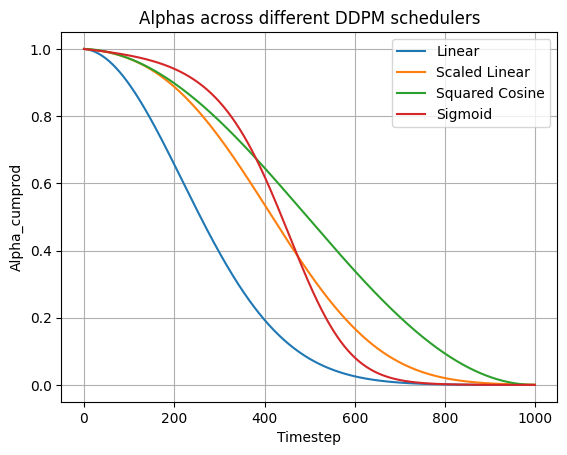

In [12]:
s_linear = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
s_scaled = DDPMScheduler(num_train_timesteps=1000, beta_schedule="scaled_linear")
s_cosine = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
s_sigmoid= DDPMScheduler(num_train_timesteps=1000, beta_schedule="sigmoid")

plt.plot(s_linear.alphas_cumprod, label="Linear")
plt.plot(s_scaled.alphas_cumprod, label="Scaled Linear")
plt.plot(s_cosine.alphas_cumprod, label="Squared Cosine")
plt.plot(s_sigmoid.alphas_cumprod, label="Sigmoid")

plt.xlabel("Timestep")
plt.ylabel("Alpha_cumprod")
plt.title("Alphas across different DDPM schedulers")
plt.legend()
plt.grid(True)
plt.show()

Let's plot what the forward process does to the above image using the above values of `betas` and `alphas`

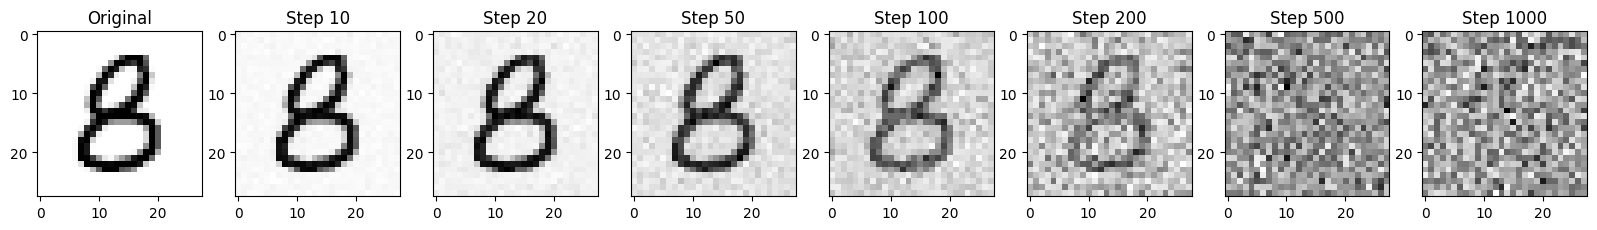

In [28]:
def diffusion_kernel(x, t, alphas):
    noise = torch.randn_like(x)
    return torch.sqrt(alphas[t]) * x + torch.sqrt(1 - alphas[t]) * noise
    
n_steps = 1000
x = example_image 
timesteps = torch.arange(0, n_steps, dtype=torch.float32)
mutated_images = [("Original", x)]
for t in [10, 20, 50, 100, 200, 500, 1000]:
    noise = torch.randn_like(x)
    z_t = diffusion_kernel(x, t-1, alphas)
    mutated_images.append((f"Step {t}", z_t))

fig, axes = plt.subplots(1, len(mutated_images), figsize=(20, 5))
for i, (title, img) in enumerate(mutated_images):
    axes[i].imshow(img.squeeze(), cmap='Grays')
    axes[i].set_title(title)
plt.show()

### Reverse Process

The goal of the reverse process is to learn $p(\mathbf{z}_{t-1} | \mathbf{z}_t)$, which reverses the forward noise process. Using Bays's theorem:
$$p(\mathbf{z}_{t-1} | \mathbf{z}_t) = 
\frac{p(\mathbf{z}_{t} | \mathbf{z}_{t-1})p(\mathbf{z}_{t-1})}{p(\mathbf{z}_t)}$$

which can be rewritten as:
$$
\begin{align*} p(\mathbf{z}_{t-1} | \mathbf{z}_t, \mathbf{x}) &= 
\frac{p(\mathbf{z}_{t} | \mathbf{z}_{t-1}, \mathbf{x})p(\mathbf{z}_{t-1} \mid \mathbf{x})}{p(\mathbf{z}_t \mid \mathbf{x})}\\
&=
\frac{p(\mathbf{z}_{t} | \mathbf{z}_{t-1})p(\mathbf{z}_{t-1} \mid \mathbf{x})}{p(\mathbf{z}_t \mid \mathbf{x})}\\
&\propto
p(\mathbf{z}_{t} | \mathbf{z}_{t-1})p(\mathbf{z}_{t-1} \mid \mathbf{x})\\
&\approx \mathcal{N}_{\mathbf{z}_{t-1}}(\mathbf{\mu}_\theta(\mathbf{z}_t, \mathbf{x}), \sigma_{t}^2 \mathbf{I})
\end{align*}
$$

where:
- $p(\mathbf{z}_{t} | \mathbf{z}_{t-1}, \mathbf{x}) = p(\mathbf{z}_{t} | \mathbf{z}_{t-1})= \mathcal{N}_{\mathbf{z}_t}( \sqrt{1 - \beta_t} \mathbf{z}_{t-1}, \beta_t \mathbf{I})$ --- from the Markov property.
- $p(\mathbf{z}_{t-1} \mid \mathbf{x}) = \mathcal{N}_{\mathbf{z}_{t-1}}( \sqrt{\alpha_{t-1}} \mathbf{x}, (1 - \alpha_{t-1}) \mathbf{I})$.
- $p(\mathbf{z}_t \mid \mathbf{x})$ is a constant with respect to $\mathbf{z}_{t-1}$.
- $\mathbf{\mu}_\theta(\mathbf{z}_t, \mathbf{x}) = \frac{(1 - \alpha_{t-1}) \sqrt{1-\beta_t} \mathbf{z}_t + \sqrt{\alpha_{t-1}}\beta_t \mathbf{x}}{1 - \alpha_t}$ is the predicted mean, modeled by a deep neural network. For images, this could be a U-Net-based network.
- $\sigma_{t}^2 = \frac{\beta_t(1 - \alpha_{t-1})}{1 - \alpha_t}$ is the variance.

In practice, however, $\mathbf{x}$ in $\mathcal{N}_{\mathbf{z}_{t-1}}(\mathbf{\mu}_\theta(\mathbf{z}_t, \mathbf{x}), \sigma_{t}^2 \mathbf{I})$ is unknown during generation. And while the network $\mathbf{\mu}_\theta(\mathbf{z}_t, \mathbf{x})$ can be used to predict the mean of $\mathbf{z}_{t-1}$, it is better and easier to predict the noise that needs to be subtracted from $\mathbf{z}$ to obtain $\mathbf{z}_{t-1}$.

In other words, given a neural network $g(\mathbf{z}_t, \theta, t)$ that predict the noise: 
  - $\mathbf{x}$ can be approximated as:
  $$\mathbf{x} \approx \frac{\mathbf{z}_t}{\sqrt{\alpha_t}} - \frac{\sqrt{1 - \alpha}_t}{\sqrt{\alpha_t}} \text{ . }g(\mathbf{z}_t, \theta, t)$$
  - And $\mathbf{\mu}_\theta(\mathbf{z}_t, \mathbf{x})$ is re-written as:
$$\mathbf{\mu}_\theta(\mathbf{z}_t, \theta, t) = \frac{1}{\sqrt{1-\beta_t}} \left( \mathbf{z}_t - \frac{\beta_t}{\sqrt{1 - \alpha}_t} \text{ . }g(\mathbf{z}_t, \theta, t) \right)$$

It is important to note that, to avoid creating a separate model for each timestep (which could number in the thousands), we instead ensure that the model $g(\mathbf{z}_t, \theta, t)$ is parameterized by $t$. This can be implemented using positional embeddings, as we will see later.

### Implementing the Decoder Model

Next we implement decoder model $g(\mathbf{z}_t, \theta, t)$ as a simple U-Net. To make this model accept timestep $t$, we first create positioning embedding similar that used in the original transformer paper.

The positional encoding used in the original Transformer paper (Vaswani et al., 2017) is defined as:

$$
PE_{(t, 2i)} = \sin\left(\frac{t}{10000^{\frac{2i}{d}}}\right)
$$

$$
PE_{(t, 2i+1)} = \cos\left(\frac{t}{10000^{\frac{2i}{d}}}\right)
$$

where:
- $t$ is the timestep or position index,
- $i$ is the dimension index,
- $d$ is the total embedding dimension.

Here is the implementation

In [49]:
from torch import nn

def positioning_embedding(n, d):
    embedding = torch.zeros(n, d)
    w = torch.tensor([1 / 10_000 ** (2 * i / d) for j in range(d)])
    w = w.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * w[:,::2])
    embedding[:,1::2] = torch.cos(t * w[:,::2])

    return embedding

Next we implement a simple U-Net model. This will be our decoder model, that looks like this:

In [50]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out
        
class BasicUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super().__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = positioning_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

### Sampling
This model, once trained, can be used to generate new images. Such a process is called **Sampling**. It takes the following steps:

- **Given** a trained model $g(\mathbf{z}_t, \theta, t)$ and a **noise variance schedule** $\beta_1, \beta_2, \dots, \beta_T$
- $\mathbf{z}_T \sim \mathcal{N}(0, \mathbf{I})$
- **For** $t \in \{ T, \dots, 2\}$:
  - $\alpha_t = \prod_{s=1}^{t} 1 - \beta_t$
  - $\mathbf{\mu}_\theta(\mathbf{z}_t, \theta, t) = \frac{1}{\sqrt{1-\beta_t}} \left( \mathbf{z}_t - \frac{\beta_t}{\sqrt{1 - \alpha}_t} \text{ . }g(\mathbf{z}_t, \theta, t) \right)$
  - $\epsilon \sim \mathcal{N}(0, \mathbf{I})$
  - $\mathbf{z}_{t-1} = \mathbf{\mu}_\theta(\mathbf{z}_t, \theta, t) + \sqrt{\beta_t} \text{ . } \epsilon$
- Calculate the output: 
$$\mathbf{x} = \frac{1}{\sqrt{1-\beta_1}} \left( \mathbf{z}_1 - \frac{\beta_1}{\sqrt{1 - \alpha}_1} \text{ . }g(\mathbf{z}_1, \theta, 1) \right)$$

Let's implement this function, while we are at it, let's also create a function for showing grid of images. We'll need this function to visualize the sampled (new) images.

First the sampling process:

In [80]:
from diffusers import UNet2DModel

def sample(model, device, n_samples=16, img_shape=(1, 28, 28), n_steps=1000):
    with torch.inference_mode():
        c, h, w = img_shape
        
        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for t in reversed(range(n_steps)):
            # Predicting the noise at timestep t to remove
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            predicted_noise = model(x, t).sample if isinstance(model, UNet2DModel) else model(x, time_tensor)

            beta_t = betas[t]
            alpha_t = alphas[t]

            # Partially denoising the image
            x = (1 / (1-beta_t).sqrt()) * (x - (beta_t) / (1 - alpha_t).sqrt() * predicted_noise)

            if t > 0:
                eps = torch.randn(n_samples, c, h, w).to(device)
                x = x + beta_t.sqrt() * eps

    return x

And then the `show_images` function:

In [76]:
def show_images(images, title="", figsize=(8, 8)):
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    fig = plt.figure(figsize=figsize)
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)

            if i < len(images):
                plt.imshow(images[i][0], cmap="Greys")
                plt.xticks([])
                plt.yticks([])
                i += 1
                
    fig.suptitle(title)
    plt.show()

### Training the Decoder Model
We are ready to create a decoder model :

In [57]:
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timesteps = 1000
betas = linear_beta_schedule(timesteps).to(device)
alphas = torch.cumprod(1.0 - betas, dim=0)

model = BasicUNet().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
BasicUNet                                --
├─Embedding: 1-1                         (100,000)
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       101
│    └─SiLU: 2-2                         --
│    └─Linear: 2-3                       2
├─Sequential: 1-3                        --
│    └─MyBlock: 2-4                      --
│    │    └─LayerNorm: 3-1               1,568
│    │    └─Conv2d: 3-2                  100
│    │    └─Conv2d: 3-3                  910
│    │    └─SiLU: 3-4                    --
│    └─MyBlock: 2-5                      --
│    │    └─LayerNorm: 3-5               15,680
│    │    └─Conv2d: 3-6                  910
│    │    └─Conv2d: 3-7                  910
│    │    └─SiLU: 3-8                    --
│    └─MyBlock: 2-6                      --
│    │    └─LayerNorm: 3-9               15,680
│    │    └─Conv2d: 3-10                 910
│    │    └─Conv2d: 3-11                 910
│  

Before we train this model, let's have it create 64 new images. 

Generating new images


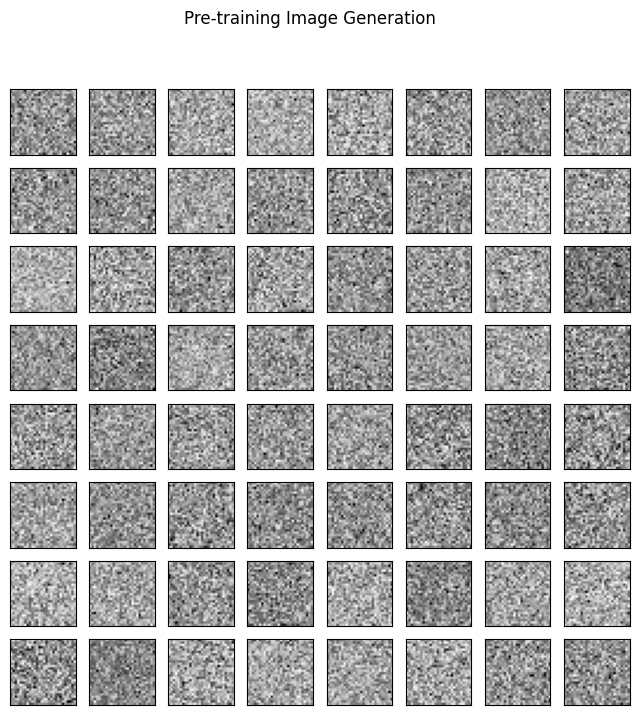

In [64]:
generated_images = sample(model, device, n_samples=64)

show_images(generated_images, "Pre-training Image Generation")

Obvoisly these images are pure noise and look nothing like hand-written digits. Now we train the model. We will be using the Adam optimizer and the MSE loss. Here is our training loop. You will need a GPU for this, and depending on the kind of GPU you have, this can take between 15-30 minutes.

In [66]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
epochs = 50

hist = dict(loss=[0] * epochs)
for epoch in range(epochs):
  for images, _ in dl_train:
    # images = batch["images"]
    batch_size = images.shape[0]
    images = images.to(device)
      
    # Randomly select a timestep for the batch
    t = torch.randint(0, timesteps, (batch_size,), device=images.device)

    # Add noise to the images using the diffusion kernel
    noise = torch.randn_like(images)
    alpha = alphas[t].view(batch_size, 1, 1, 1)
    noisy_images = torch.sqrt(alpha) * images + torch.sqrt(1 - alpha) * noise

    # Predict noise at timestep t
    predicted_noise = model(noisy_images, t)

    # Compute the loss between predicted noise and actual noise
    loss = loss_fn(predicted_noise, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    hist['loss'][epoch] += loss.item()
      
  hist['loss'][epoch] /= len(dl_train)
  if epoch == 0 or (epoch + 1) % 2 == 0:
      print(f"Epoch {epoch + 1: 3d}: loss={hist['loss'][epoch]:.4f}")

Epoch   1: loss=0.1667
Epoch   2: loss=0.0576
Epoch   4: loss=0.0434
Epoch   6: loss=0.0375
Epoch   8: loss=0.0351
Epoch  10: loss=0.0335
Epoch  12: loss=0.0324
Epoch  14: loss=0.0312
Epoch  16: loss=0.0311
Epoch  18: loss=0.0305
Epoch  20: loss=0.0301
Epoch  22: loss=0.0299
Epoch  24: loss=0.0296
Epoch  26: loss=0.0292
Epoch  28: loss=0.0294
Epoch  30: loss=0.0290
Epoch  32: loss=0.0291
Epoch  34: loss=0.0285
Epoch  36: loss=0.0284
Epoch  38: loss=0.0286
Epoch  40: loss=0.0284
Epoch  42: loss=0.0281
Epoch  44: loss=0.0280
Epoch  46: loss=0.0279
Epoch  48: loss=0.0279
Epoch  50: loss=0.0278


Here is what the loss learning curve looks like:

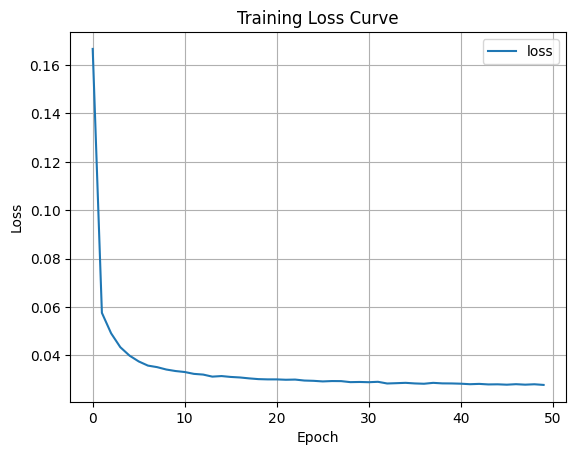

In [67]:
import pandas as pd

pd.DataFrame(hist).plot(grid=True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

which looks great.

To see how we did, let's have this trained model generate another patch of 64 images.

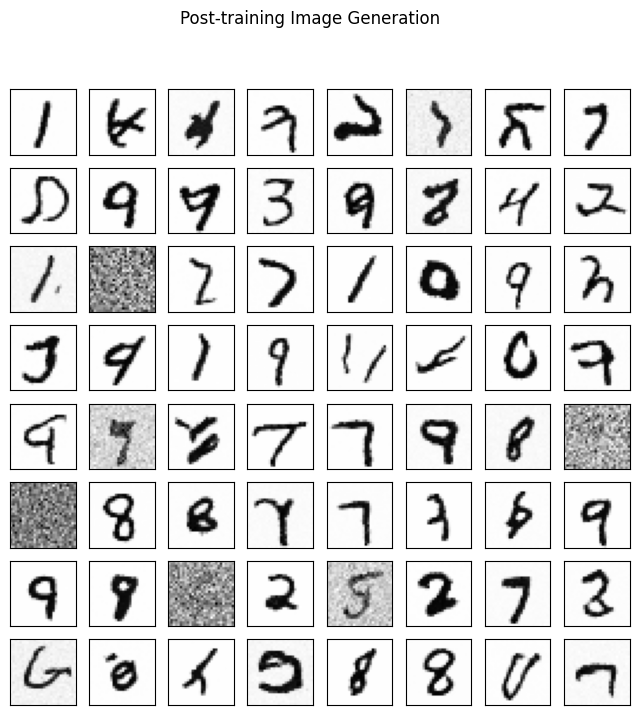

In [68]:
generated_images = sample(model, device, n_samples=64)
show_images(generated_images, "Post-training Image Generation")

This is much much better, and as you see. We can see hand-written digits. We still have a few quality issues that can be improved by bigger model and longer training.

Before moving on to the next step, let's save this model. We spent a lot of time training it.

In [69]:
torch.save(model.state_dict(), 'ddpm_from_strach.pth')

which we can load and sample from later like this:

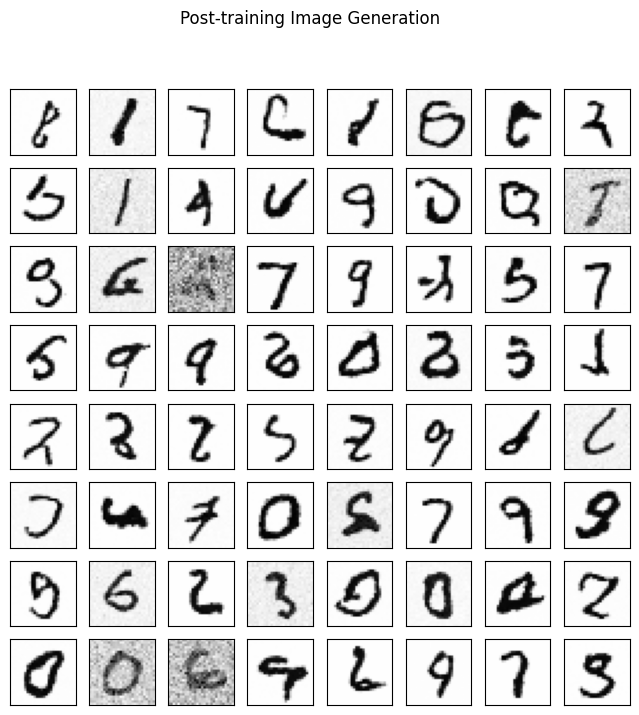

In [81]:
loaded_model = BasicUNet().to(device)
loaded_model.load_state_dict(torch.load('ddpm_from_strach.pth'))
loaded_model.eval()

show_images(sample(loaded_model, device, n_samples=64), "Post-training Image Generation")

### Using UNet2DModel

The model we just trained was implemented from scratch and did OK. Let's switch models to a UNet-based model named `UNet2dModel` from the `diffusers` package.

In [72]:
from diffusers import UNet2DModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
).to(device)

summary(model)

Layer (type:depth-idx)                        Param #
UNet2DModel                                   --
├─Conv2d: 1-1                                 320
├─Timesteps: 1-2                              --
├─TimestepEmbedding: 1-3                      --
│    └─Linear: 2-1                            4,224
│    └─SiLU: 2-2                              --
│    └─Linear: 2-3                            16,512
├─ModuleList: 1-4                             --
│    └─DownBlock2D: 2-4                       --
│    │    └─ModuleList: 3-1                   45,504
│    │    └─ModuleList: 3-2                   9,248
│    └─AttnDownBlock2D: 2-5                   --
│    │    └─ModuleList: 3-3                   33,536
│    │    └─ModuleList: 3-4                   148,352
│    │    └─ModuleList: 3-5                   36,928
│    └─AttnDownBlock2D: 2-6                   --
│    │    └─ModuleList: 3-6                   33,536
│    │    └─ModuleList: 3-7                   164,736
├─ModuleList: 1-5          

As you can see, this is a much bigger model with attension layers and Resnet blocks. Before training it, let's sample a few images from it.

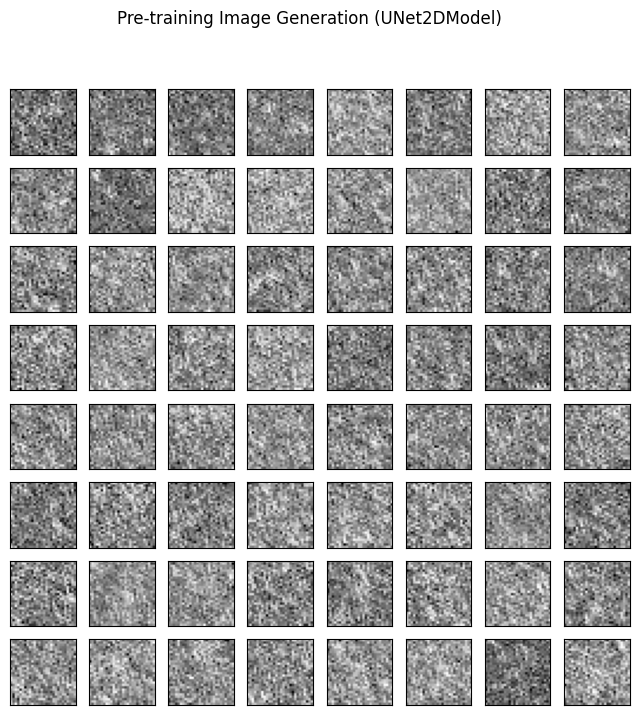

In [82]:
show_images(sample(model, device, n_samples=64), "Pre-training Image Generation (UNet2DModel)")

As expected, this is pure noise. Now we train the model. Let's train it for only 10 epochs.

In [83]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
epochs = 10

hist = dict(loss=[0] * epochs)
for epoch in range(epochs):
  for images, _ in dl_train:
    # images = batch["images"]
    batch_size = images.shape[0]
    images = images.to(device)
      
    # Randomly select a timestep for the batch
    t = torch.randint(0, timesteps, (batch_size,), device=images.device)

    # Add noise to the images using the diffusion kernel
    noise = torch.randn_like(images)
    alpha = alphas[t].view(batch_size, 1, 1, 1)
    noisy_images = torch.sqrt(alpha) * images + torch.sqrt(1 - alpha) * noise

    # Predict noise at timestep t
    predicted_noise = model(noisy_images, t).sample

    # Compute the loss between predicted noise and actual noise
    loss = loss_fn(predicted_noise, noise)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    hist['loss'][epoch] += loss.item()
      
  hist['loss'][epoch] /= len(dl_train)
  if epoch == 0 or (epoch + 1) % 2 == 0:
      print(f"Epoch {epoch + 1: 3d}: loss={hist['loss'][epoch]:.4f}")

Epoch   1: loss=0.0479
Epoch   2: loss=0.0292
Epoch   4: loss=0.0255
Epoch   6: loss=0.0241
Epoch   8: loss=0.0236
Epoch  10: loss=0.0232


Here is the learning curve:

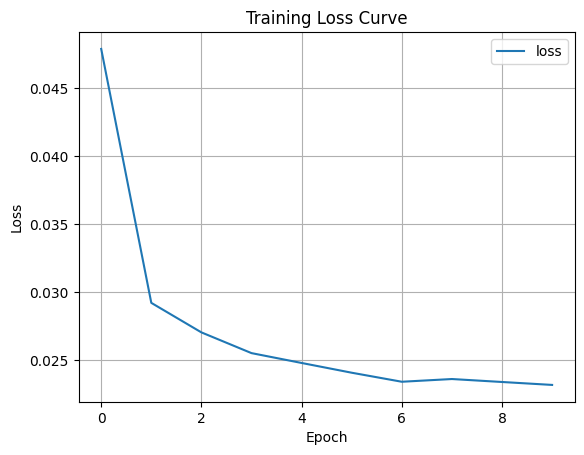

In [84]:
pd.DataFrame(hist).plot(grid=True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

Let's save this model:

In [85]:
torch.save(model.state_dict(), 'ddpm_UNet2DModel.pth')

And here is a sample of generated images.

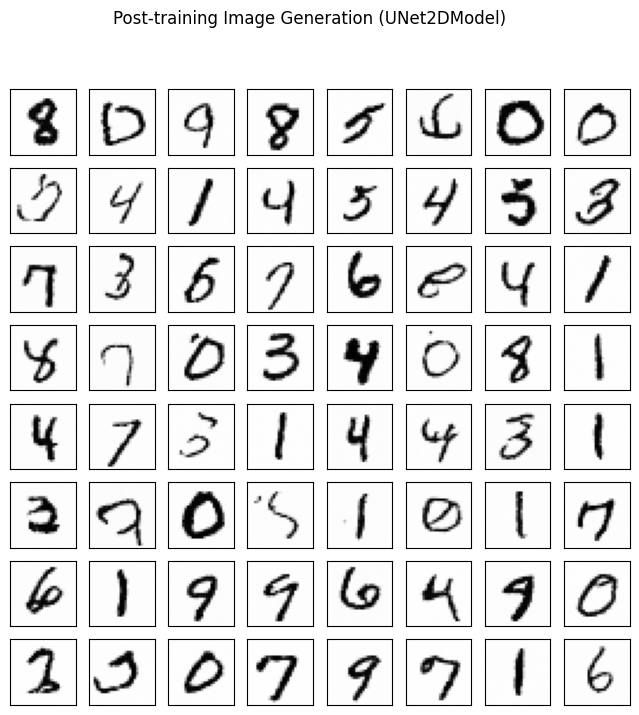

In [86]:
show_images(sample(model, device, n_samples=64), "Post-training Image Generation (UNet2DModel)")

Nice! Even for 10 epoch, this is a much better model thanks to more parameters, batch normalization, and self-attention.

### What is next?

Now that you know how DDPMs work, check out HuggingFace's Diffusion course or download a pretrained Diffusion Stable from HuggingFace and use it generate new images using prompts. Yes diffusion models work well with transformer-based models.

Happy learning!

In [161]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
).to(device)